# Expected Value of Cost function in population setting

In [8]:
import numpy as np
import matplotlib.pyplot as plt

## Generate $n$D Data

In [9]:
def generate_data_nD(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), Sigma))
    
    return series

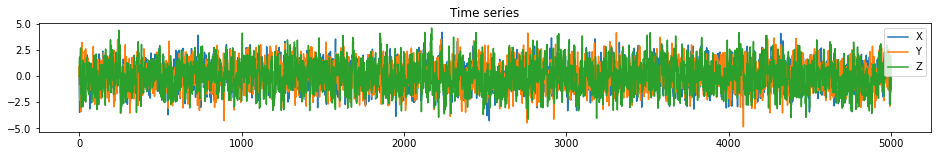

In [19]:
np.random.seed(seed = 123)

length, n = 5000, 3
A, P, Sigma = None, None, None 

if n == 2:
    A = np.array([[0.5, 0.0], [0.8, 0.4]])
    P = np.array([[1.0, 0.0], [0.0, 1.0]])
    Sigma = np.identity(n)
elif n == 3:
    A = np.array([[0.5, 0.0, 0.0], [0.3, 0.4, 0.0], [0.2, 0.0, 0.6]])
    Sigma = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    
elif n == 4:
    
    P = np.array([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]])


# Generate nD data
series = generate_data_nD(length, n, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

# Cost Function
$$C(A, P, A^*, P^*) = \left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2,$$
where we use the following value to predict $X_t$:
$$X_{t,pred} = P^{-1}APX_{t-1}$$
In reality, there is some underlying $P^*$, $A^*$ used to generate $X_{t,val}:$
$$X_{t, val} = P^{*-1}A^*P^*X_{t-1} + \Sigma.$$

This means that the cost function is 
$$C(A, P, A^*, P^*) = \left\lVert P^{*-1}A^*P^*X_{t-1} + \Sigma- P^{-1}APX_{t-1}\right\rVert_2^2,$$

## Distribution of $X$
We assume that $X_1 \sim \mathcal{N}\left(\mathbf{0}, \Sigma\right)$. Then, the distribution of $X_t$, where $t$ can be any integer, will be

$$X_t \sim \mathcal{N}\left(0, \Sigma_X\right),$$

where $$\text{vec}(\Sigma_X) = \left(I_{n^2} - B^* \otimes B^*\right)^{-1} \text{vec}(\Sigma),$$

and $$B^* = P^{*-1} A^* P^*.$$

More specifically, we have

$$\Sigma_X = \left(\text{vec}\left(I_n\right)^T \otimes I_m\right)\left(I_n \otimes \text{vec}(\Sigma_X) \right).$$

In [20]:
# Analytic one
B = np.matmul(np.linalg.inv(P), np.matmul(A, P))
cov_analytic_vec = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(B, B)), Sigma.reshape(n ** 2))

# Analytical derivation
cov_analytic = np.matmul(np.kron(np.identity(n).reshape(n ** 2).transpose(), np.identity(n)), np.kron(np.identity(n), cov_analytic_vec).transpose())
cov_analytic_2 = cov_analytic_vec.reshape((n, n))

def is_pos_def(x):
    return np.linalg.eigvals(x)

print(is_pos_def(cov_analytic))

# Data one
cov_data = np.cov(series.transpose())

# Print results, should be equal for length -> \infty
print("Analtic approach 1:\n", np.round(cov_analytic, 2))
print("\nAnalytic approach 2:\n", np.round(cov_analytic_2, 2))
print("\nData sampling approach:\n", np.round(cov_data, 2))
print("\nElement-wise difference:\n", np.round((cov_analytic - cov_data), 2))

[1.93267283 1.11482903 1.40785528]
Analtic approach 1:
 [[1.33 0.25 0.19]
 [0.25 1.4  0.18]
 [0.19 0.18 1.72]]

Analytic approach 2:
 [[1.33 0.25 0.19]
 [0.25 1.4  0.18]
 [0.19 0.18 1.72]]

Data sampling approach:
 [[1.28 0.27 0.19]
 [0.27 1.39 0.27]
 [0.19 0.27 1.78]]

Element-wise difference:
 [[ 0.06 -0.02 -0.  ]
 [-0.02  0.01 -0.09]
 [-0.   -0.09 -0.06]]


# Distribution of $\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]$
To derive the expectation of the cost, we first rewrite to
\begin{align*}
    \mathbb{E}\left[\left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2\right] &= \mathbb{E}\left[\sum_{i=1}^n \left(X_{t,val,i} - X_{t,pred,i} \right)^2\right]\\
    &= \text{Tr}\left(\mathbb{V}\left(X_{t,val} - X_{t, pred})\right)\right) \\
\end{align*}
coSo, we see that we need to determine the covariance of $X_{t,val} - X_{t,pred}$, or rather its trace. We derive the variance as follows:

\begin{align*}
\mathbb{V}\left(X_{t,val} - X_{t, pred})\right) &= \mathbb{V}\left(P^{*-1}A^*P^* X_{t-1} + \Sigma - P^{-1}APX_{t-1})\right)\\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t-1}\right)&\tag{Due to independence of $\Sigma$} \\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t}\right)&\tag{$X_t$, $X_{t-1}$ have same distribution} \\
&= \Sigma + \left(B^* - B\right)\mathbb{V}\left(X_{t}\right)\left(B^* - B\right)^T &\tag{Constant out of covariance}\\
&= \Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T, \tag{Fill in $\Sigma_X$}\\
\end{align*}
where $$B^* = P^{*-1} A^* P^*,\qquad B = P^{-1} A P.$$
Hence, 
$$\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] = \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right).$$

Furthermore, we see that the expected cost is a function of our data-generating $P^*$, $A^*$, and of our estimates $P$, $A$.

In [21]:
def expected_cost(A, P, As, Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

We see that the analytic approach and the data sampling approach yield almost identical results, with the data sampling approach converging to the analytic approach when we take an infinite amount of samples.
## Expected cost when using $P^*$ and $A^*$
\begin{align*}\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] &= \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right) \\
&= \text{Tr}\left(\Sigma + \left(B^* - B^*\right)\Sigma_X\left(B^* - B^*\right)^T\right) \\
&= \text{Tr}\left(\Sigma\right).
\end{align*}
Hence, we see that we achieve the minimum for $P^*$ and $A^*$.

In [22]:
def C_n(A = A, P = P):
    """
    Given that series has been generated according to P*, A*,
    This function returns the cost when using estimates P, A.
    """
    
    cost = 0

    P_inv = np.linalg.inv(P)

    for t in range(1, length):
        val = series[t]
        est = np.matmul(P_inv, np.matmul(A, np.matmul(P, series[t - 1])))
        cost += np.linalg.norm(val - est) ** 2

    return cost / (length - 1)

print("Expected Cost when using P* and A*:", np.trace(Sigma))
print("Expected Cost when using P* and A*:", expected_cost(A, P, A, P))
print("Cost from data when using P* and A*:", round(C_n(), 3))

Expected Cost when using P* and A*: 3.0
Expected Cost when using P* and A*: 3.0
Cost from data when using P* and A*: 2.996


## Expected Cost for different $P$

In [23]:
import itertools
P_list = np.array(list(itertools.permutations(np.identity(n))))

for P_2 in P_list:
    print("\nPermutation:\n", P_2)
    print("Expected cost:", round(expected_cost(A, P_2, A, P), 2))
    print("Cost from data:", round(C_n(A, P_2), 2))


Permutation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Expected cost: 3.0
Cost from data: 3.0

Permutation:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Expected cost: 3.13
Cost from data: 3.14

Permutation:
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
Expected cost: 3.33
Cost from data: 3.33

Permutation:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
Expected cost: 3.41
Cost from data: 3.4

Permutation:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Expected cost: 3.44
Cost from data: 3.46

Permutation:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Expected cost: 3.41
Cost from data: 3.41


## Expected cost for different $A$

In [24]:
# np.random.seed(seed = 1)
for _ in range(5):
    A_2 = np.random.rand(n, n)
    print("\nA:\n", np.round(A_2, 2))
    print("Expected cost:", round(expected_cost(A_2, P, A, P), 2))
    print("Cost from data:", round(C_n(A_2, P), 2))


A:
 [[0.3  0.78 0.68]
 [0.59 0.55 0.14]
 [0.03 0.55 0.42]]
Expected cost: 5.43
Cost from data: 5.48

A:
 [[0.03 0.08 0.23]
 [0.54 0.92 0.15]
 [0.09 0.02 0.06]]
Expected cost: 4.48
Cost from data: 4.52

A:
 [[0.87 0.5  0.47]
 [0.57 0.06 0.34]
 [0.86 0.29 0.5 ]]
Expected cost: 5.34
Cost from data: 5.26

A:
 [[0.43 0.11 0.38]
 [0.2  0.64 0.2 ]
 [0.36 1.   0.4 ]]
Expected cost: 4.94
Cost from data: 4.88

A:
 [[0.69 0.17 0.68]
 [0.56 0.34 0.53]
 [0.11 0.82 0.42]]
Expected cost: 5.52
Cost from data: 5.47


## Expected cost for different $A$ and $P$

In [25]:
import itertools
P_list = np.array(list(itertools.permutations(np.identity(n))))

for P_2 in P_list:
    A_2 = np.random.rand(n, n)
    print("\nPermutation:\n", P_2)
    print("\nA:\n", A_2)
    print("Expected cost:", round(expected_cost(A_2, P_2, A, P), 2))
    print("Cost from data:", round(C_n(A_2, P_2), 2))


Permutation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

A:
 [[0.37123388 0.83081614 0.5663456 ]
 [0.35845696 0.00629147 0.47417241]
 [0.81618535 0.76570716 0.49546496]]
Expected cost: 6.7
Cost from data: 6.63

Permutation:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]

A:
 [[0.82926131 0.32731506 0.35782324]
 [0.83250518 0.96678904 0.72543723]
 [0.90086544 0.14712515 0.78118467]]
Expected cost: 6.46
Cost from data: 6.47

Permutation:
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

A:
 [[0.41608975 0.14269748 0.19175087]
 [0.92238701 0.92813507 0.49527398]
 [0.03184671 0.74335503 0.42492191]]
Expected cost: 5.8
Cost from data: 5.85

Permutation:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]

A:
 [[0.91919319 0.69337184 0.5419265 ]
 [0.26811243 0.06024314 0.80286991]
 [0.58389822 0.32476913 0.12558292]]
Expected cost: 6.29
Cost from data: 6.33

Permutation:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]

A:
 [[0.4318974  0.03987274 0.97037298]
 [0.55929901 0.83574825 0.90790409]
 [0.30169076 0.30564453 0.42690631]]
Expected

## Expected cost for doubly stochastic matrix

In [17]:
A_2 = np.random.rand(n, n)
P_DS = np.array([[0.2, 0.8], [0.8, 0.2]])
print("\nP_DS:\n", P_DS)
print("\nA:\n", A_2)
print("Expected cost:", round(expected_cost(A_2, P_DS, A, P), 2))
print("Cost from data:", round(C_n(A_2, P_DS), 2))


P_DS:
 [[0.2 0.8]
 [0.8 0.2]]

A:
 [[0.33177785 0.78546986]
 [0.46148833 0.20164153]]
Expected cost: 2.45
Cost from data: 2.45


# Question, do we attain a global minimum for $A = A^*$, $P = P^*$?
Answer: Yes! To see this, note that when $A = A^*$, $P = P^*$, we have that $B = B^*$. Then,
\begin{align*}
\mathbb{V}\left(X_t - X_{t, pred})\right) &= \mathbb{V}\left(P^{*-1}A^*P^* X_{t-1} + \Sigma - P^{-1}APX_{t-1})\right)\\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t-1}\right) \\
&= \Sigma + \mathbb{V}\left(\mathbf{O}X_{t-1}\right) \\
&= \Sigma,\\
\end{align*}
where $\mathbf{O}$ represents the matrix which has zero for all entries. 

## Question: Is the minimum unique?
Answer: Not necessarily. Consider a lower triangular matrix 
$$A^* = \begin{pmatrix} 0.5 & 0 & 0 \\ 0.3 & 0.4 & 0 \\ 0.2 & 0 & 0.6\end{pmatrix},\qquad P^* = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{pmatrix}.$$
We see that $X_2$ is influenced by $X_1$, and $X_3$ is influenced by $X_1$, but there is no interaction between $X_2$ and $X_3$. Hence, we argue that we can reach the same optimal cost with

$$A = \begin{pmatrix} 0.5 & 0 & 0 \\ 0.2 & 0.6 & 0 \\ 0.3 & 0 & 0.4\end{pmatrix},\qquad P = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \\ 0 & 1 & 0\end{pmatrix}.$$

In [18]:
A_2 = np.array([[0.5, 0.0, 0.0], [0.2, 0.6, 0.0], [0.3, 0.0, 0.4]])
P_2 = np.array([[1, 0, 0], [0, 0, 1], [0, 1, 0]])
print("Actual A*:\n", A)
print("Actual P*:\n", P)

print("\nOther A:\n", A_2)
print("\nOther P:\n", P_2)

print("Expected cost:", round(expected_cost(A_2, P_2, A, P), 2))
print("Cost from data:", round(C_n(A_2, P_2), 2))

Actual A*:
 [[0.5 0. ]
 [0.8 0.4]]
Actual P*:
 [[1. 0.]
 [0. 1.]]

Other A:
 [[0.5 0.  0. ]
 [0.2 0.6 0. ]
 [0.3 0.  0.4]]

Other P:
 [[1 0 0]
 [0 0 1]
 [0 1 0]]


ValueError: operands could not be broadcast together with shapes (2,2) (3,3) 

## Real Question: If the permutation is unique, is there any $P$ (can be DS) and $A$ that attain the minimum as well?
Answer: This would be true if and only if:
\begin{align*}
\text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right) = 0.
\end{align*}
As $\Sigma_X$ is a covariance matrix, we now it is also positive semi-definite, meaning that 
$$x\Sigma_Xx^T \geq \mathbf{0}.$$
Hence, 
$$\text{Diag}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right) = \mathbf{0}.$$
In other words, rather than the diagonal entries $\textit{summing}$ to zero, we require that $\textit{each}$ of the diagonal entries is 0.

Moreover, if the covariance matrix is positive definite, then $$x\Sigma_Xx^T > \mathbf{0}.$$
So, we have a strict inequality if $\Sigma_X$ is positive definite, meaning that we can only attain the minimum if $$B^* = B \iff P^{*-1}A^*P^* = P^{-1}AP.$$

If the permutation $P^*$ is unique, then we cannot find another permutation matrix $\hat{P}$ and a lower triangular matrix $\hat{A}$ such that $\hat{P}^{-1}\hat{A}\hat{P} = B^*$. Hence, if the permutation matrix is unique, then there is only one permutation that achieves this global minimum in the population setting.

However, what if $P$ can be doubly stochastic? It turns out that when all entries of $A$ were freely choosable, then we can find $A$, $P_{DS}$ such that $P^{-1}_DS A P_{DS}$ such that $P^{-1}_DS A P_{DS} = B^*$, where $P_{DS} \neq P^*$, $A \neq A^*$.

Consider the setting where 

$$P^* = \begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix}, \qquad A^* = \begin{pmatrix} 0.5 & 0 \\ 0.8 & 0.4 \end{pmatrix}.$$
Then, $$B^* = A^*.$$ However, consider now
$$\hat{P} = \begin{pmatrix} 0.25 & 0.75 \\ 0.75 & 0.25\end{pmatrix}, \qquad \hat{A} = \frac{1}{80}\begin{pmatrix} 7 & 75  \\ -11 & 65 \end{pmatrix}.$$
Then $$\hat{B} = B^*,$$
meaning that we $\textbf{indeed}$ can find a $P_{DS}$, $A$ such that we can attain the minimum. However, this matrix $A$ is not lower triangular. If $A$ is constrained to be lower triangular, then we could not find a 2D example such that $P^{-1}AP = B^*$, apart from $A = A^*, P = P^*$, although this proposition is not formally proven. 

Hypothesis: When restricting $A$ to be LT, there do not exist $A \neq A^*$, $P \neq P^*$, even when $P$ is DS such that $P^{-1}AP = B^*$. Hence, when the permutation is unique, the global minimizer is unique as well in the population setting, even when we relax to DS matrices $P$.

In [40]:
print(A, P)
print("Expected Cost when using P* and A*:", expected_cost(A, P, A, P))
P_2 = np.array([[0.25, 0.75], [0.75, 0.25]])
A_2 = np.array([[0.0875, 0.9375], [-0.1375, 0.8125]])
print(np.matmul(np.linalg.inv(P_2), np.matmul(A_2, P_2)))
print(A)
print("Expected Cost when using P_2 and A_2:", expected_cost(A_2, P_2, A, P))

[[0.5 0. ]
 [0.8 0.4]] [[1. 0.]
 [0. 1.]]
Expected Cost when using P* and A*: 2.0
[[0.5 0. ]
 [0.8 0.4]]
[[0.5 0. ]
 [0.8 0.4]]
Expected Cost when using P_2 and A_2: 2.0


## Real Question 2: How can be find such a minimum?
Answer: By finding a matrix $B$ that is as close to $B^*$ as possible. Or equivalently, by finding $P$, $A$, such that $P^{-1} A P$ is as close to $P^{*-1} A^* P^*$ as possible. However, we do $\textbf{not}$ have any information about $P^*$, $A^*$, we need to find this from data.